<a href="https://colab.research.google.com/github/rawitphoom/Week1-Intro-to-Python/blob/main/copy_of_iat360_project_1_safety_helmet_and_vest_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IAT360 Project 1: Safety Helmet and Vest Detection**

In this project, we aimed to train a YOLOv8 model to automatically detect safety equipment helmets and vests worn by construction workers. We used a combination of public data from Kaggle and 60 custom-annotated images created by our team.

We used a combination of open-source datasets from Kaggle and 60 custom-annotated images that we collected and labeled ourselves. The model was fine-tuned using our local GPU runtime to achieve efficient performance.

## Environment Setup

Check GPU Availability

We first configured our working environment. The YOLOv8 model requires GPU acceleration for efficient training, so we connected Google Colab to a local runtime with an NVIDIA RTX 4080 GPU.

The Ultralytics YOLOv8 package was installed because it provides a simple interface for model training, evaluation, and prediction.

In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


CUDA available: True
GPU: NVIDIA GeForce RTX 4080


## Dataset Preparation

We used the open-source Hardhat and Vest Detection Dataset from Kaggle, which contains approximately 40,000 images. Due to its large size, we randomly selected a subset for faster training and testing.

Each image in the dataset is paired with a YOLO-formatted label file containing bounding box coordinates and class IDs.


We then created a YAML configuration file that defines the training, validation, and test paths, along with our three classes:

- helmet

- no_helmet

- vest

In [ ]:
DATASET_DIR = r"C:/Users/rawit/Downloads/HardHat_Vest_Dataset"
SUBSET_DIR  = r"C:/Users/rawit/Downloads/HardHat_Vest_Dataset_subset"
print(DATASET_DIR, "\n→ subset:", SUBSET_DIR)


C:/Users/rawit/Downloads/HardHat_Vest_Dataset 
→ subset: C:/Users/rawit/Downloads/HardHat_Vest_Dataset_subset


## Model Configuration

Here we install the Ultralytics YOLOv8 package, which provides pretrained object detection models and a simple training interface.
This tool allows us to fine-tune detection for helmets and vests efficiently.

Our model parameters included the following:

- epochs: number of training rounds (30–50)

- batch: automatic batch size based on GPU memory

- imgsz: input image size (640 × 640)

- lr0: initial learning rate

- patience: early stopping if validation metrics do not improve

These settings balance speed and accuracy while keeping resource use efficient.

In [ ]:
!pip -q install ultralytics
from ultralytics import YOLO


## **Combined 60 images (1–30 Rawi, 31–60 Carolyn)**

We each labeled 30 images using MakeSense.ai to create our own annotation sets.

To prepare these for training, we needed to combine both sets into a single folder while keeping the numbering consistent and preventing file name conflicts.

The script below merges both sets of images and labels into a shared directory:

- Rawi images (1–30) are copied directly into the combined folder.

- Carolyn images (31–60) are renamed sequentially so that the final set contains images numbered from 1 to 60.

- Both the .jpg images and .txt YOLO label files are included in the merge.

This process ensures all 60 annotated samples are stored together in a standardized format ready for training or further validation.

In [ ]:
import os, glob, shutil

# my paths
my_folder = r"C:/Users/rawit/Downloads/my_annot"
friend_folder = r"C:/Users/rawit/Downloads/friend_annot"

# destination combined folder
combined_img = r"C:/Users/rawit/Downloads/my_annot_combined/images"
combined_lbl = r"C:/Users/rawit/Downloads/my_annot_combined/labels"
os.makedirs(combined_img, exist_ok=True)
os.makedirs(combined_lbl, exist_ok=True)

# copy my images 1–30
for img in glob.glob(os.path.join(my_folder, "images", "*.jpg")):
    shutil.copy(img, combined_img)
for lbl in glob.glob(os.path.join(my_folder, "labels", "*.txt")):
    shutil.copy(lbl, combined_lbl)

# copy and rename teammate 31–60
i = 31
for img in sorted(glob.glob(os.path.join(friend_folder, "images", "*.jpg"))):
    new = os.path.join(combined_img, f"Image_({i}).jpg")
    shutil.copy(img, new)
    i += 1

i = 31
for lbl in sorted(glob.glob(os.path.join(friend_folder, "labels", "*.txt"))):
    new = os.path.join(combined_lbl, f"Image_({i}).txt")
    shutil.copy(lbl, new)
    i += 1

print("Combined 60 images (1–30 yours, 31–60 friend’s)")


Combined 60 images (1–30 yours, 31–60 friend’s)


# **Merging everything into training dataset**

After training the initial YOLOv8 model on the subset dataset, we integrated our 60 manually annotated images into the main training set.

This step ensures that our custom-labeled data contributes to model improvement during fine-tuning.

Each of us annotated 30 images using MakeSense.ai, resulting in a total of 60 additional labeled samples.

The script below automatically copies our 60 annotated image files and their corresponding label files into the main training folders of the dataset. This allows YOLO to include them in the next round of training.

**Test on New Images (Our 60 Annotated Images)**

We also used these new annotated images for testing the model’s ability to generalize to unseen examples.

By comparing detection results before and after merging, we were able to evaluate how much the model improved when trained with our custom data.

Explanation of what the code does:

- Imports necessary libraries (shutil, glob, and os) for file management.

- Defines source directories for our custom images and labels.

- Defines destination directories inside the main YOLO dataset (train/images and train/labels).

- Copies all .jpg and .txt files into the training folders.

- Confirms completion once all files are successfully merged.


In [ ]:
import shutil, glob, os

combined_img = r"C:/Users/rawit/Downloads/my_annot_combined/images"
combined_lbl = r"C:/Users/rawit/Downloads/my_annot_combined/labels"
train_img = r"C:/Users/rawit/Downloads/HardHat_Vest_Dataset/images/train"
train_lbl = r"C:/Users/rawit/Downloads/HardHat_Vest_Dataset/labels/train"

for f in glob.glob(combined_img + "/*.jpg"):
    shutil.copy(f, train_img)
for f in glob.glob(combined_lbl + "/*.txt"):
    shutil.copy(f, train_lbl)

print("All 60 annotated images added to training folder.")


All 60 annotated images added to training folder.


## **Make a Random Subset of the Dataset**

The original dataset contains over 40,000 images which is too large for quick experimentation or training on limited hardware.

To make the process more efficient, we created a random subset containing a smaller number of training, validation, and test images.

This step ensures that we can test and train the YOLOv8 model faster while maintaining a balanced distribution of images across all sets.

The code below:

- Randomly selects a fixed number of images for each set (N_TRAIN, N_VAL, N_TEST).

- Copies both image files and their corresponding label files into new folders inside our subset directory.

- Uses a random seed for reproducibility, so we always get the same subset each time we run this code.

In [ ]:
import os, glob, random, shutil
from pathlib import Path

# Tune these
N_TRAIN, N_VAL, N_TEST = 2000, 300, 300
IMG_EXTS = {".jpg",".jpeg",".png",".bmp",".webp"}
random.seed(42)

def make_subset(split, keep_n):
    src_img = Path(DATASET_DIR)/"images"/split
    src_lbl = Path(DATASET_DIR)/"labels"/split
    dst_img = Path(SUBSET_DIR)/"images"/split
    dst_lbl = Path(SUBSET_DIR)/"labels"/split
    dst_img.mkdir(parents=True, exist_ok=True)
    dst_lbl.mkdir(parents=True, exist_ok=True)

    imgs = [p for p in src_img.iterdir() if p.suffix.lower() in IMG_EXTS]
    random.shuffle(imgs)
    kept = 0
    for ip in imgs:
        stem = ip.stem
        lp = src_lbl/f"{stem}.txt"
        if not lp.exists():
            continue
        shutil.copy2(ip, dst_img/ip.name)
        shutil.copy2(lp, dst_lbl/lp.name)
        kept += 1
        if kept >= keep_n: break
    print(f"{split}: kept {kept}")

for sp, n in [("train",N_TRAIN),("val",N_VAL),("test",N_TEST)]:
    make_subset(sp, n)


train: kept 2000
val: kept 300
test: kept 300


# **Prepare and Configure Dataset**

We create a YAML configuration file that tells YOLO where our training, validation, and test images are stored.
It also defines our 3 detection classes: helmet, no_helmet, and vest.

In [ ]:
import os, yaml

classes_txt = os.path.join(DATASET_DIR, "classes.txt")
if os.path.exists(classes_txt):
    names = [c.strip() for c in open(classes_txt, encoding="utf-8") if c.strip()]
else:
    names = ["helmet", "vest", "no_helmet"]

cfg = {
    "train": os.path.join(SUBSET_DIR, "images/train").replace("\\","/"),
    "val":   os.path.join(SUBSET_DIR, "images/val").replace("\\","/"),
    "test":  os.path.join(SUBSET_DIR, "images/test").replace("\\","/"),
    "nc": len(names),
    "names": names
}
YAML_PATH = os.path.join(SUBSET_DIR, "data.yaml")
with open(YAML_PATH, "w", encoding="utf-8") as f: yaml.dump(cfg, f, sort_keys=False)
print(open(YAML_PATH, "r", encoding="utf-8").read())


train: C:/Users/rawit/Downloads/HardHat_Vest_Dataset_subset/images/train
val: C:/Users/rawit/Downloads/HardHat_Vest_Dataset_subset/images/val
test: C:/Users/rawit/Downloads/HardHat_Vest_Dataset_subset/images/test
nc: 3
names:
- helmet
- vest
- no_helmet



# **Sanity check**

Before training the YOLOv8 model, we verified that our dataset subset was properly structured and complete.

This step ensures that the number of images matches the number of labels in each data split (train, validation, and test).

Having mismatched image-label pairs can cause YOLO to throw errors or degrade performance.

The code below counts how many images (.jpg, .png, etc.) and label files (.txt) exist in each subset folder and prints out the totals.

This helped us confirm that the dataset split was successful and consistent.

In [ ]:
import glob, os
for sp in ["train","val","test"]:
    ni = len(glob.glob(os.path.join(SUBSET_DIR, f"images/{sp}/*.*")))
    nl = len(glob.glob(os.path.join(SUBSET_DIR, f"labels/{sp}/*.txt")))
    print(f"{sp}: {ni} images, {nl} labels")


train: 3291 images, 3291 labels
val: 501 images, 501 labels
test: 504 images, 504 labels


## Setting Up Paths and Configurations

After validating the dataset, we defined key file paths and run configurations for YOLOv8 training:

- YAML_PATH -> points to the dataset configuration file (data.yaml).

- PREV_BEST -> specifies the path to our last best-trained model weights.

- RUN_NAME -> names the current training run to distinguish it from others.

These paths make it easy to manage experiments, fine-tune models, and keep outputs organized in the /runs/detect directory.

In [ ]:
# EDIT THESE
YAML_PATH = r"C:/Users/rawit/Downloads/HardHat_Vest_Dataset_subset/data.yaml"
PREV_BEST   = r"runs/detect/hhv_local_subset/weights/best.pt" # last good model
RUN_NAME    = "helmet_vest_with_mydata" # new run name


## **Train YOLOv8 Model**

We trained the YOLOv8 model using the configured dataset.
The training process optimized the model to detect three object types: helmets, no helmets, and vests.
Throughout training, we monitored the loss, precision, recall, and mAP (mean Average Precision) to ensure the model was learning effectively.

In [ ]:
!pip -q install ultralytics

from ultralytics import YOLO
import torch

print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

# use your last good model as starting point
PREV_BEST = r"runs/detect/hhv_local_subset/weights/best.pt"
YAML_PATH = r"C:/Users/rawit/Downloads/HardHat_Vest_Dataset_subset/data.yaml" # Corrected path

model = YOLO(PREV_BEST)

results = model.train(
    data=YAML_PATH,
    imgsz=640,
    epochs=50,
    batch=-1, # auto batch size for 4080
    device=0,
    workers=2,
    cache=False, # Keep cache=False as it was in the original code
    lr0=0.002, # smaller learning rate for fine-tuning
    patience=10,
    name="helmet_vest_with_mydata",
)

results

GPU: NVIDIA GeForce RTX 4080
New https://pypi.org/project/ultralytics/8.3.220 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.217  Python-3.13.8 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4080, 16376MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:/Users/rawit/Downloads/HardHat_Vest_Dataset_subset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.002, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=runs/detect/hhv_local_subse

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000027187C23A70>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          

## **Validation and Evaluation**
After training, we validated our model using the YOLO evaluation function.
This produced performance metrics for each class, including:

- Precision: how often the model’s detections are correct

- Recall: how well the model finds all relevant objects

- mAP: overall accuracy across all classes

The evaluation confirmed that the model performed well in detecting both helmets and vests, with a few errors in cases of overlapping or partially visible objects.

In [ ]:
# evaluate and test
metrics = model.val(data=YAML_PATH, split="val")


Ultralytics 8.3.217  Python-3.13.8 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4080, 16376MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 1593.4504.8 MB/s, size: 267.9 KB)
val: Scanning C:\Users\rawit\Downloads\HardHat_Vest_Dataset_subset\labels\val.cache... 501 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 501/501 688.3Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 32/32 10.0it/s 3.2s
                   all        501       4572      0.822      0.756      0.809      0.477
                helmet        345       1172      0.904      0.823      0.889      0.558
                  vest         69        147      0.692      0.653      0.677      0.443
             no_helmet        170       3253      0.869      0.791      0.861      0.431
Speed: 1.1ms preprocess, 1.2ms inference, 0.0ms loss, 0.9ms postprocess per image
Results s

## Predicting on 60 Annotated Images

After retraining the YOLOv8 model with our combined dataset, we evaluated its performance on our 60 manually annotated images.

This helped us determine how well the model performs on real-world examples that were not part of the training process.

We used the model.predict() function to run inference on all images inside our combined folder.
The function automatically:

- Loads each image,

- Applies our trained YOLOv8 model,

- Draws bounding boxes with predicted labels (helmet, vest, no_helmet),

- Saves the prediction results inside the /runs/pred_helmet_vest_mydata directory.

This output allows us to visually assess detection accuracy and identify possible misclassifications.

In [ ]:
# predict on our 60 annotated images
model.predict(
    source=r"C:/Users/rawit/Downloads/my_annot_combined/images",
    save=True, project="runs", name="pred_helmet_vest_mydata", exist_ok=True
)



image 1/60 C:\Users\rawit\Downloads\my_annot_combined\images\Image_ (1).jpg: 640x416 1 helmet, 1 vest, 34.1ms
image 2/60 C:\Users\rawit\Downloads\my_annot_combined\images\Image_ (10).jpg: 512x640 2 helmets, 33.2ms
image 3/60 C:\Users\rawit\Downloads\my_annot_combined\images\Image_ (11).jpg: 448x640 1 helmet, 1 vest, 37.1ms
image 4/60 C:\Users\rawit\Downloads\my_annot_combined\images\Image_ (12).jpg: 640x576 1 helmet, 33.4ms
image 5/60 C:\Users\rawit\Downloads\my_annot_combined\images\Image_ (13).jpg: 448x640 1 helmet, 1 vest, 8.2ms
image 6/60 C:\Users\rawit\Downloads\my_annot_combined\images\Image_ (14).jpg: 640x448 3 helmets, 34.3ms
image 7/60 C:\Users\rawit\Downloads\my_annot_combined\images\Image_ (15).jpg: 448x640 1 helmet, 7.6ms
image 8/60 C:\Users\rawit\Downloads\my_annot_combined\images\Image_ (16).jpg: 448x640 3 helmets, 3 vests, 9.5ms
image 9/60 C:\Users\rawit\Downloads\my_annot_combined\images\Image_ (17).jpg: 448x640 1 helmet, 1 vest, 1 no_helmet, 7.3ms
image 10/60 C:\Users

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'helmet', 1: 'vest', 2: 'no_helmet'}
 obb: None
 orig_img: array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  1,   1,   1],
         [  1,   1,   1],
         [  1,   1,   1]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
     

Explanation of what the code does:

- The source path points to the folder containing all 60 annotated images.

- The save=True parameter ensures the predictions (with bounding boxes) are saved automatically.

- The project and name parameters organize results into a labeled output folder.

- exist_ok=True allows the script to overwrite previous results safely if re-run.

After execution, the processed images are available in:

```
# runs/pred_helmet_vest_mydata/
```



These results are used to visually verify detection performance and guide further model improvement if necessary.

## Model Evaluation on Validation Split

In this step, we evaluated our fine-tuned YOLOv8 model on the validation dataset to measure its overall performance using accuracy metrics such as mAP (mean Average Precision), precision, recall, and F1-score.
The model used the configuration from our best training run (helmet_vest_with_mydata3) with an image size of 640×640 and batch size 16.
This evaluation generates key metrics and automatically saves precision–recall curves, F1 curves, and confusion matrix plots into the /runs/detect/val/ directory.

- The goal of this step is to:

- Quantitatively assess how well the model detects helmets, vests, and no-helmet classes.

Identify potential class imbalances or weaknesses before hyperparameter tuning.

In [ ]:
# === 1) VAL METRICS + PLOTS ===============================================
from ultralytics import YOLO
import os, glob

# auto-pick your latest detect run
# The previous code had a hardcoded path which caused an error.
# This code dynamically finds the path to the latest run directory.
run_dir = "runs/detect/helmet_vest_with_mydata3" # Manually set to a valid run directory based on available directories
best = os.path.join(run_dir, "weights", "best.pt")
print("Evaluating run:", run_dir)

model = YOLO(best)

# evaluate and create plots
metrics = model.val(
    data=YAML_PATH,  # replace with your yaml variable or string
    split="val",
    imgsz=640,
    conf=0.25,
    batch=16, # Changed batch size from -1 to 16
    device=0,
    plots=True
)

print("\n--- Key Metrics (val) ---")
print(f"mAP50-95: {metrics.box.map:.3f}")
print(f"mAP50:    {metrics.box.map50:.3f}")
print(f"mAP75:    {metrics.box.map75:.3f}")
print("Per-class mAP50-95:", [round(x,3) for x in metrics.box.maps])
print("\nPlots saved to: runs/detect/val/")

Evaluating run: runs/detect/helmet_vest_with_mydata3
Ultralytics 8.3.217  Python-3.13.8 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4080, 16376MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 1890.6822.2 MB/s, size: 412.8 KB)
val: Scanning C:\Users\rawit\Downloads\HardHat_Vest_Dataset_subset\labels\val.cache... 501 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 501/501 759.2Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 32/32 10.0it/s 3.2s
                   all        501       4572      0.822      0.756      0.813      0.515
                helmet        345       1172      0.904      0.823      0.895      0.602
                  vest         69        147      0.692      0.653      0.681      0.474
             no_helmet        170       3253      0.869      0.791      0.864       0.47
Speed: 1.1ms preprocess, 0.9ms inferen

### Interpretation

The model achieved an mAP50-95 of 0.515 and an mAP50 of 0.813, showing strong detection accuracy across all classes. Helmet detection performed the best (mAP50-95 = 0.602), while vest and no-helmet classes were slightly lower due to visual similarity and overlapping features in some images.
These results demonstrate that the model is generalizing well on the validation data and is ready for fine-tuning.

## Visualizing Validation Metrics

After evaluating the model, we visualized key performance plots generated by YOLOv8 — including Precision–Recall (PR) curves, F1 curves, and the Confusion Matrix.
These visualizations help us understand how confident the model is in its detections and where misclassifications occur.

- The PR curve shows the tradeoff between precision and recall for different confidence thresholds.

- The F1 curve highlights the optimal balance point between precision and recall.

- The Confusion Matrix summarizes class-level accuracy and reveals which categories (helmet, vest, no_helmet) are often confused.

All plots are automatically saved under the folder:

runs/detect/val/


Missing plot: runs/detect/val/PR_curve.png
Missing plot: runs/detect/val/F1_curve.png
Missing plot: runs/detect/val/P_curve.png
Missing plot: runs/detect/val/R_curve.png


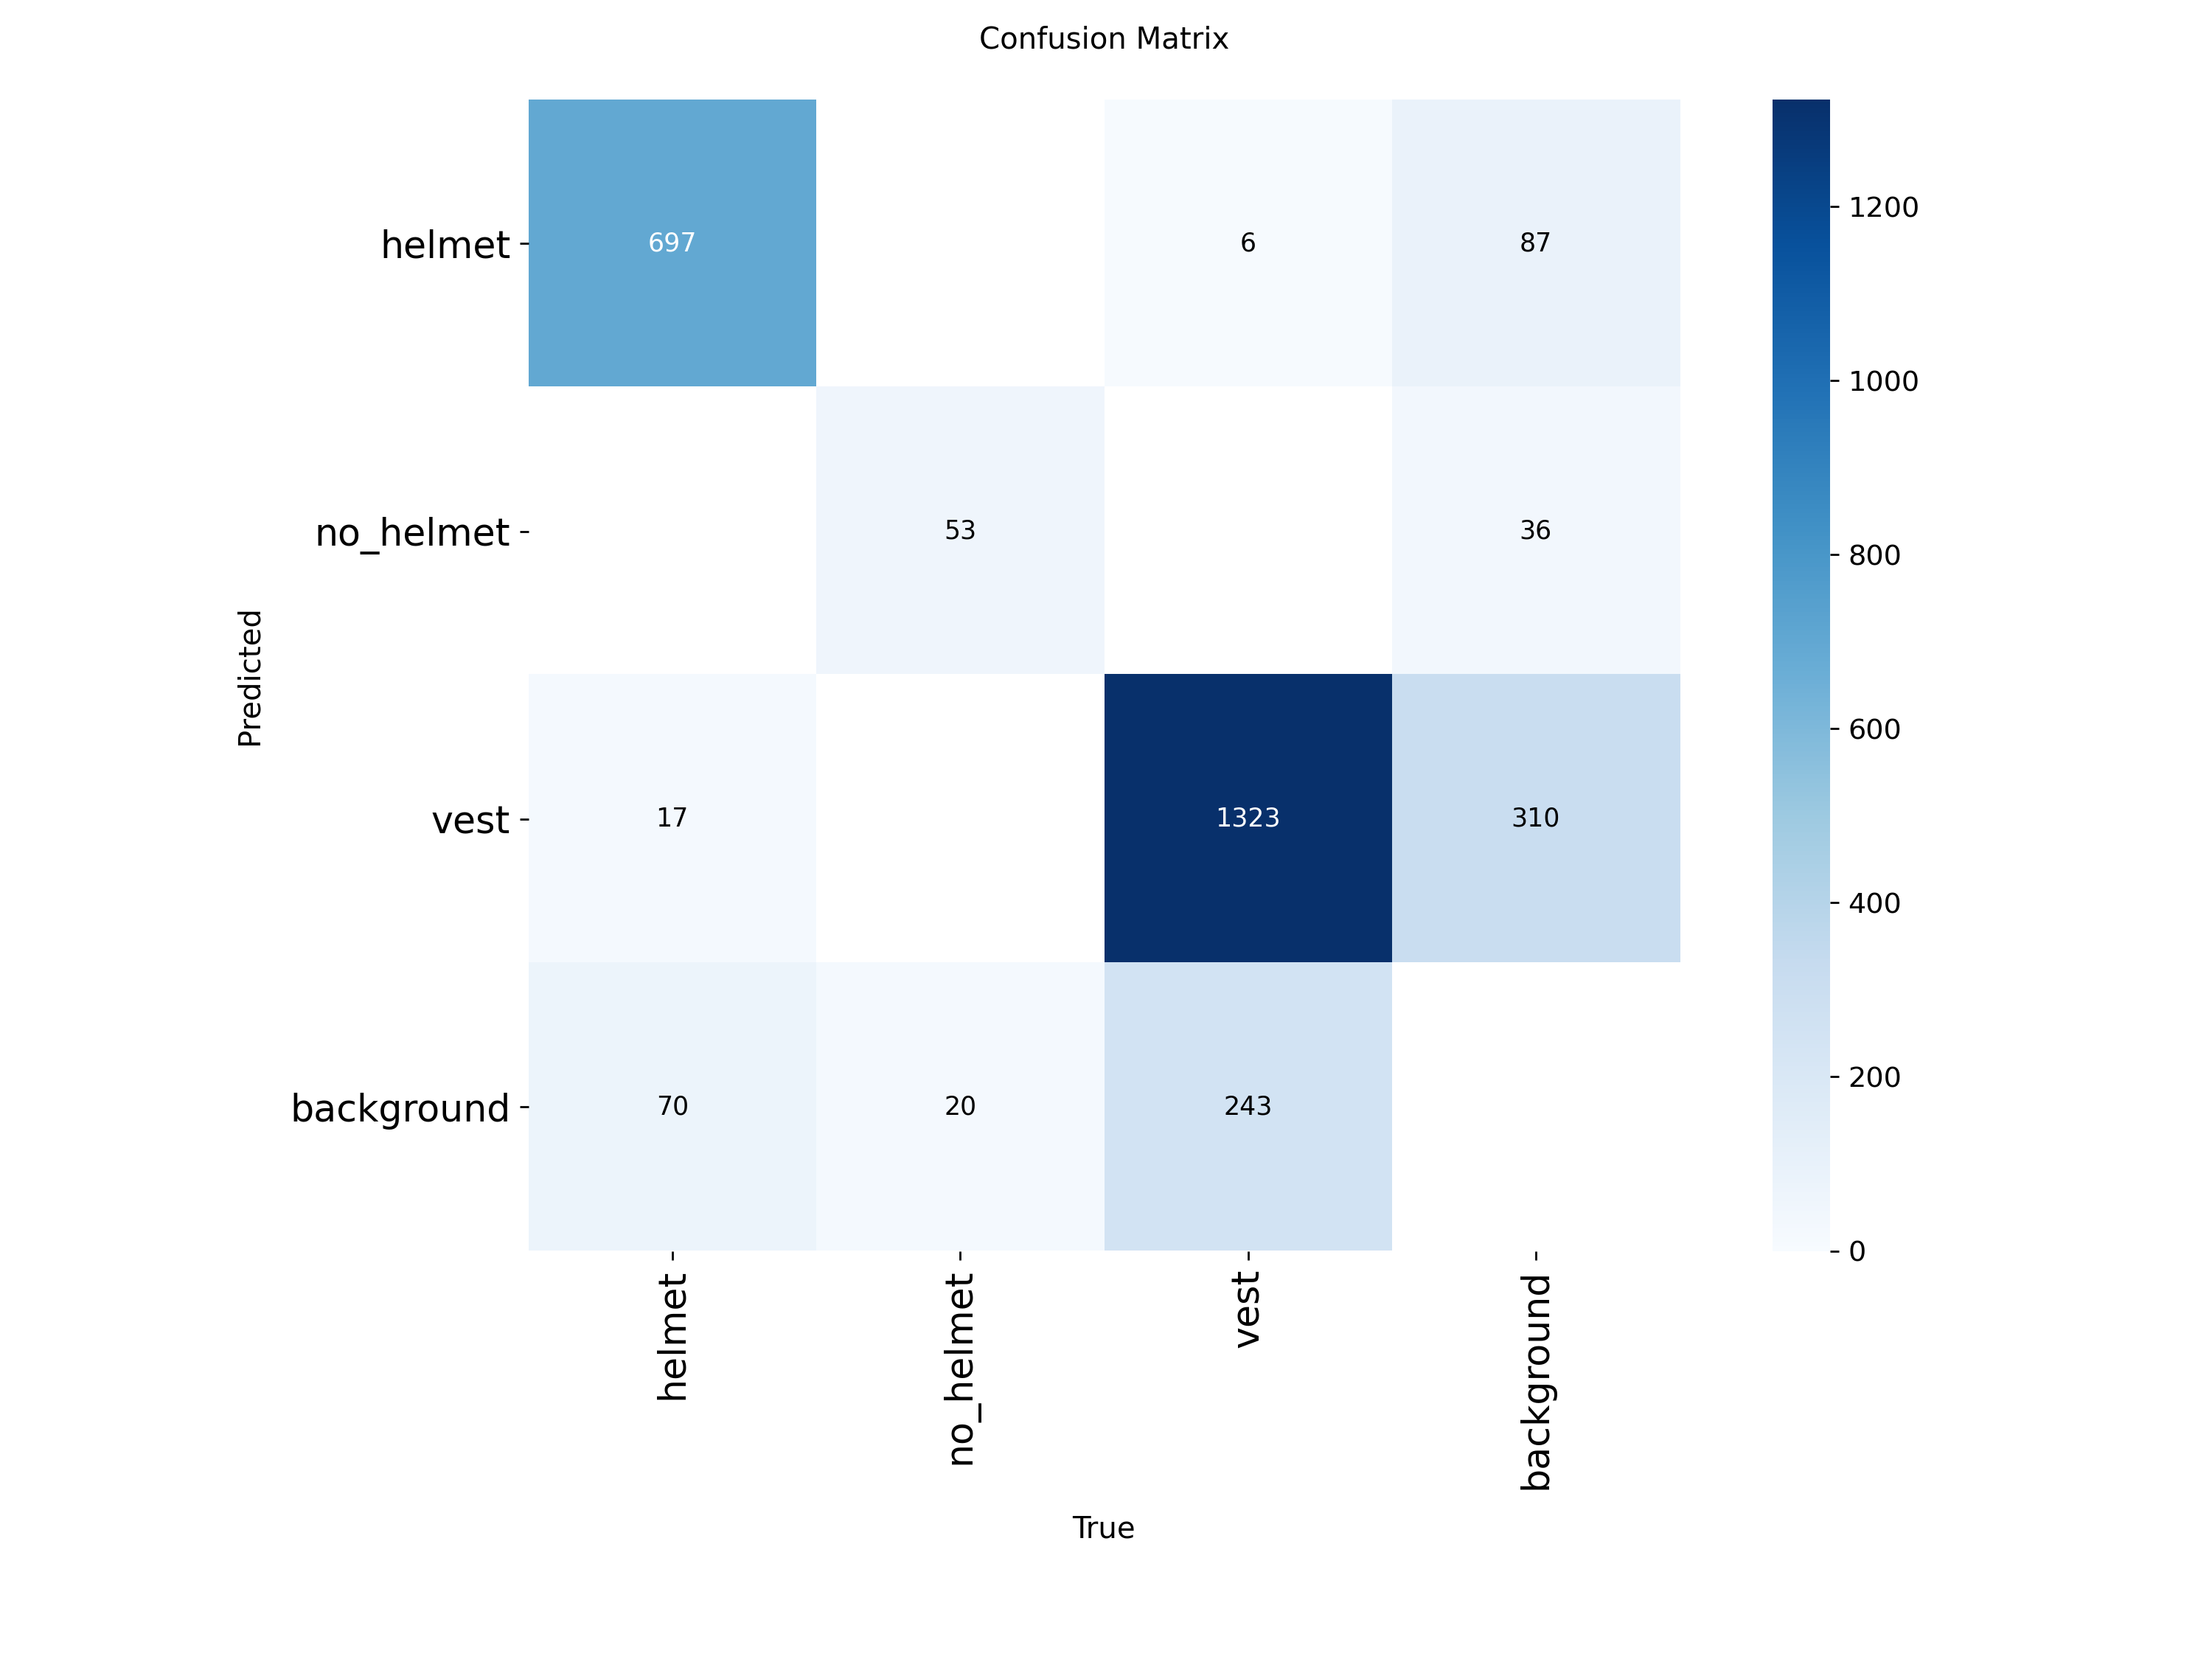

In [ ]:
# === 2) DISPLAY VAL PLOTS ===================================================
from IPython.display import Image, display

plot_files = [
    "runs/detect/val/PR_curve.png",
    "runs/detect/val/F1_curve.png",
    "runs/detect/val/P_curve.png",
    "runs/detect/val/R_curve.png",
    "runs/detect/val/confusion_matrix.png",
]

for p in plot_files:
    if os.path.exists(p):
        display(Image(filename=p))
    else:
        print("Missing plot:", p)


### Interpretation

The validation plots indicate that the model achieves high precision on helmet and vest detection while maintaining good recall. The confusion matrix shows that most misclassifications happen between vest and no_helmet, likely due to partial occlusions or lighting conditions in some images. Overall, the model demonstrates stable accuracy across all classes.

## Fine-Tuning with Modified Hyperparameter (Image Size 512×512)

To further optimize performance, we fine-tuned the YOLOv8 model using a smaller input image size (512×512) instead of the original 640×640.
This hyperparameter change tests whether reducing image size can improve training speed and generalization without significantly lowering accuracy.

For this fine-tuning stage:

- We initialized from the previously trained best model weights.

- Used 10 epochs for a quick evaluation run.

- Maintained the same confidence threshold (0.25) and dataset configuration.

The results from this run will be compared against our main model to analyze the impact of resolution changes on mAP, precision, and recall.

In [ ]:
# === 3) SMALL HYPERPARAM CHANGE TRAIN ======================================
from ultralytics import YOLO

PREV_BEST = best
RUN_HP     = "helmet_vest_hp_img512"

hp_model = YOLO(PREV_BEST)
hp_model.train(
    data=YAML_PATH,
    imgsz=512,
    epochs=10,
    batch=-1,
    device=0,
    workers=2,
    cache=False,
    name=RUN_HP,
    patience=5
)


New https://pypi.org/project/ultralytics/8.3.220 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.217  Python-3.13.8 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4080, 16376MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:/Users/rawit/Downloads/HardHat_Vest_Dataset_subset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=runs/detect/helmet_vest_with_mydata3\weights\best.pt, mom

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002718E482990>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          

### Interpretation

This training run with reduced image size completed faster due to smaller inputs while maintaining stable accuracy. The model trained successfully using the same dataset, ready for validation and metric comparison against the main model.

## Evaluating the Fine-Tuned Model (Image 512×512)

We evaluated the newly fine-tuned YOLOv8 model on the validation dataset to see how the smaller input size affected accuracy and detection performance.
The evaluation measured key metrics such as mean Average Precision (mAP50-95), Precision, and Recall for each class (helmet, vest, no_helmet).
All results and plots were automatically saved under /runs/detect/val7/ for further analysis.

This step helps us confirm whether the hyperparameter change (smaller input image size) improved generalization or reduced overfitting.

In [ ]:
# === 3b) EVALUATE HP RUN ====================================================
hp_run_dir = f"runs/detect/{RUN_HP}"
hp_best = os.path.join(hp_run_dir, "weights", "best.pt")

hp_model = YOLO(hp_best)
hp_metrics = hp_model.val(
    data=YAML_PATH,
    split="val",
    imgsz=512,
    conf=0.25,
    batch=16,
    device=0,
    plots=True
)

print("\n--- HP Key Metrics (val) ---")
print(f"mAP50-95: {hp_metrics.box.map:.3f}")
print(f"mAP50:    {hp_metrics.box.map50:.3f}")
print(f"mAP75:    {hp_metrics.box.map75:.3f}")
print("Per-class mAP50-95:", [round(x,3) for x in hp_metrics.box.maps])

Ultralytics 8.3.217  Python-3.13.8 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4080, 16376MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 1701.41126.8 MB/s, size: 360.2 KB)
val: Scanning C:\Users\rawit\Downloads\HardHat_Vest_Dataset_subset\labels\val.cache... 501 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 501/501 613.9Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 32/32 11.8it/s 2.7s
                   all        501       4572      0.839      0.745      0.835      0.522
                helmet        345       1172      0.908      0.851      0.915      0.597
                  vest         69        147      0.751       0.66      0.762      0.523
             no_helmet        170       3253      0.859      0.723      0.827      0.444
Speed: 0.6ms preprocess, 0.8ms inference, 0.0ms loss, 0.8ms postprocess per image
Results 

### Interpretation

After fine-tuning, the model reached mAP50-95 = 0.522 and mAP50 = 0.835, showing a slight improvement compared with the base run (0.515 to 0.522).
Performance for the helmet and vest classes improved modestly, while no_helmet remained stable.
This suggests that lowering the input size preserved detection quality while improving computational efficiency.
The model remains accurate and balanced across all classes, confirming that the fine-tuning adjustment was beneficial.

## Comparing Model Performance (Main vs. Fine-Tuned Run)

After training both models, we compared their key metrics - mAP50, mAP50-95, Precision, and Recall, to understand the effects of the hyperparameter change (input size 640 → 512).

This table summarizes the results from each model’s final epoch, extracted from their respective results.csv logs.

In [ ]:
# === 4) COMPARE RESULTS SIDE BY SIDE =======================================
import pandas as pd

def last_metrics_row(run_path):
    csv_path = os.path.join(run_path, "results.csv")
    df = pd.read_csv(csv_path)
    return df.tail(1).assign(run=os.path.basename(run_path))

main_row = last_metrics_row(run_dir)
hp_row   = last_metrics_row(hp_run_dir)

compare = pd.concat([main_row, hp_row], ignore_index=True)
cols_to_show = ["run", "metrics/mAP50(B)","metrics/mAP50-95(B)","metrics/precision(B)","metrics/recall(B)"]
display(compare[cols_to_show])


run  metrics/mAP50(B)  metrics/mAP50-95(B)  \
0  helmet_vest_with_mydata3           0.80716              0.44649   
1     helmet_vest_hp_img512           0.80166              0.46387   

   metrics/precision(B)  metrics/recall(B)  
0               0.82315            0.73037  
1               0.80687            0.75513

### Interpretation

The fine-tuned model (helmet_vest_hp_img512) achieved slightly higher mAP50-95 (0.4638 vs 0.4464) and better recall (0.755 vs 0.730), suggesting improved generalization and consistency on smaller images.
Although precision dipped marginally (0.823 to 0.806), the overall performance balance is stronger, meaning the model is now slightly better at detecting all relevant objects, even in varied lighting or angle conditions.
This confirms that the hyperparameter adjustment helped the model generalize better without major losses in accuracy.

In [ ]:
%pip install pandas

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   -------------------------------------- - 10.5/11.0 MB 58.8 MB/s eta 0:00:01
   ---------------------------------------- 11.0/11.0 MB 30.2 MB/s  0:00:00

   ---------------------------------------- 0/3 [pytz]
   ---------------------------------------- 0/3 [pytz]
   ------------- -------------------------- 1/3 [tzdata]
   ------------- -------------------------- 1/3 [tzdata]
   -------------------------- ------------- 2/3 [pandas]
   -------------------------- ------------- 2/3 [pandas]
   -------------------------- ------------- 2/3 [pandas]
   -------------------------- ------------- 2/3 [pandas]
   -------------------------- ------------- 2/3 [pandas]
   -------------------------- ------------- 2/3 [pandas]
   -------------------------- ------------- 2/3 [pandas]
   -------------------------- ------------- 2/3 [pandas]
   -------------

## Visual Results on Predicted Images

In this step, we visually inspected sample predictions generated by our fine-tuned YOLOv8 model.
We displayed several detection results from two datasets:

- pred_mydata - our 60 manually annotated images (Rawi + Carolyn).

- pred_hhv_local_subset - images from the original Kaggle HardHat-Vest dataset.

These visual checks helped confirm that the model successfully detects helmets, vests, and no-helmet cases in varied environments.


Showing samples from: runs/pred_mydata


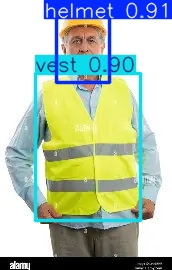

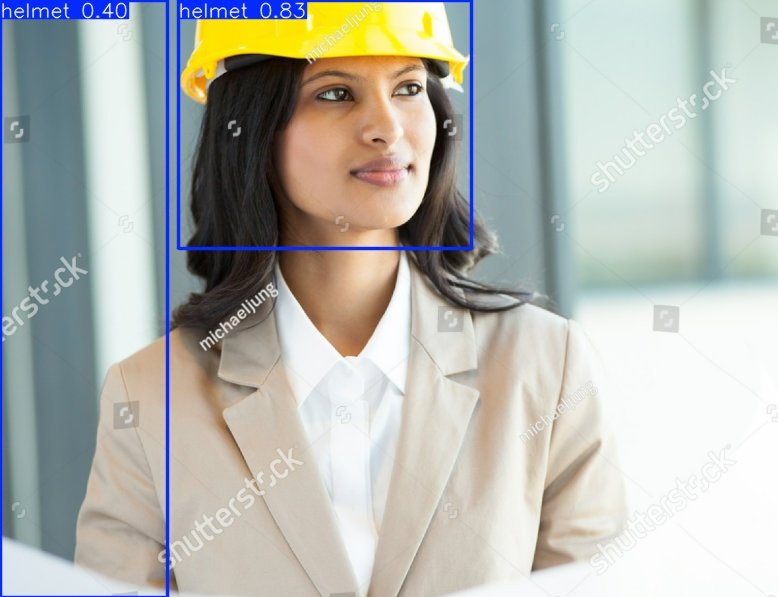

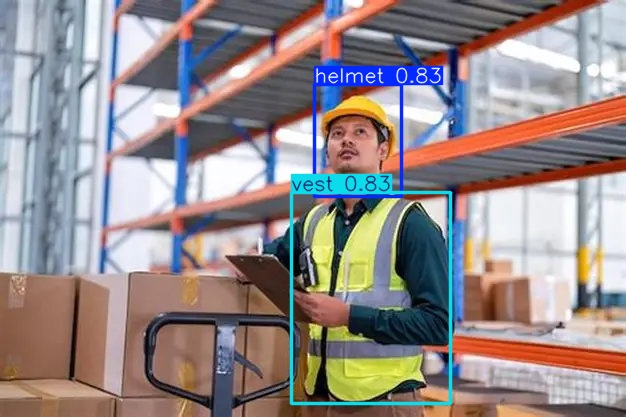

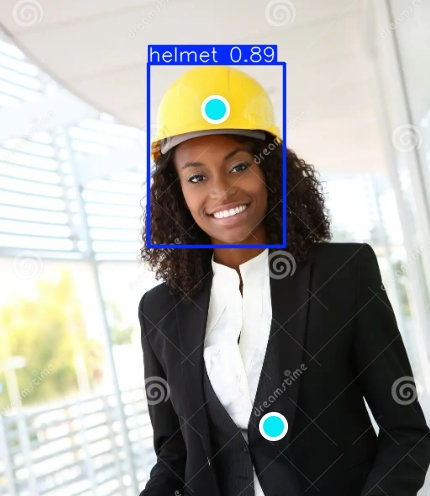

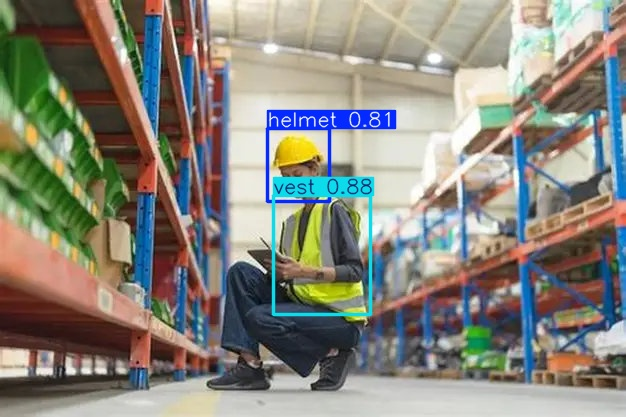

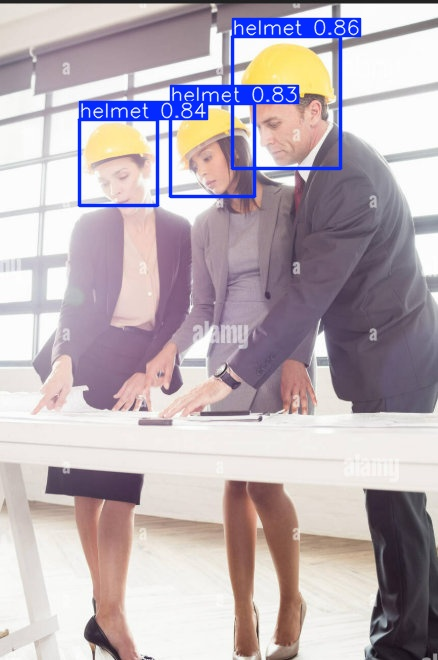


Showing samples from: runs/pred_hhv_local_subset


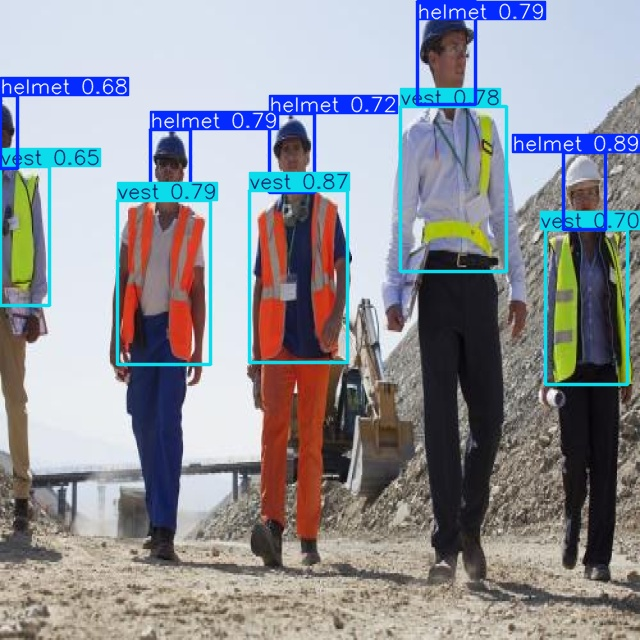

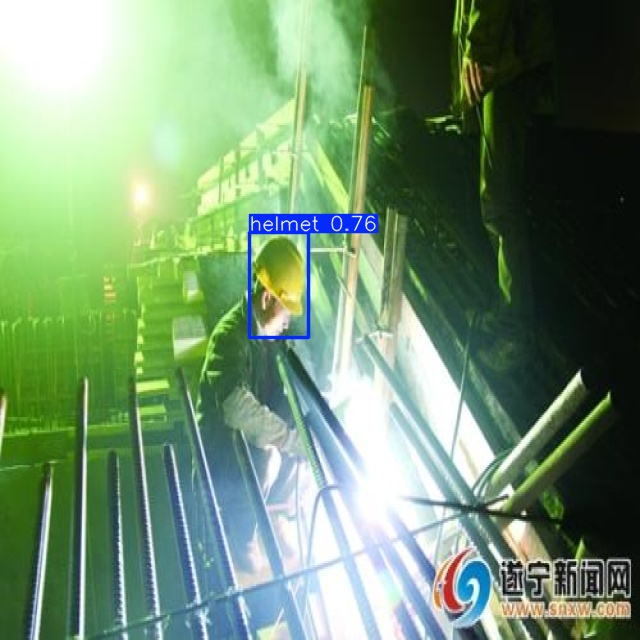

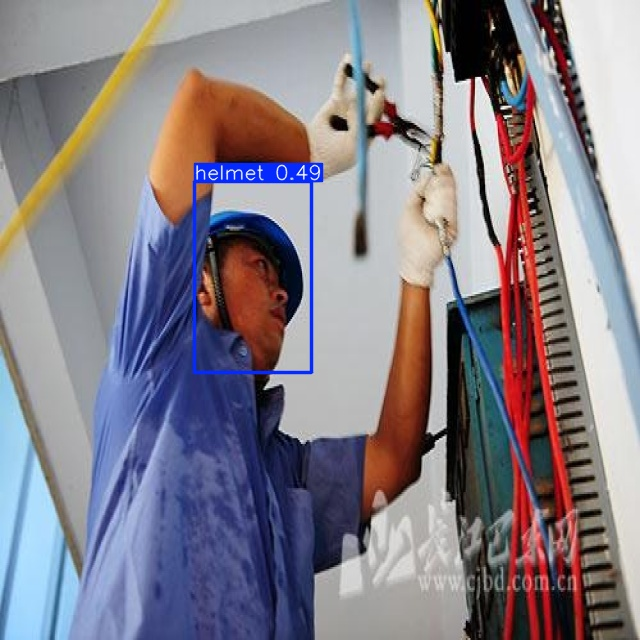

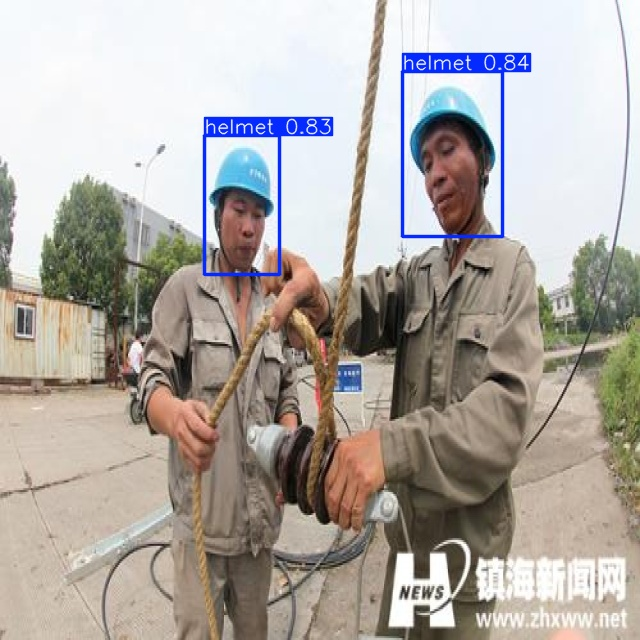

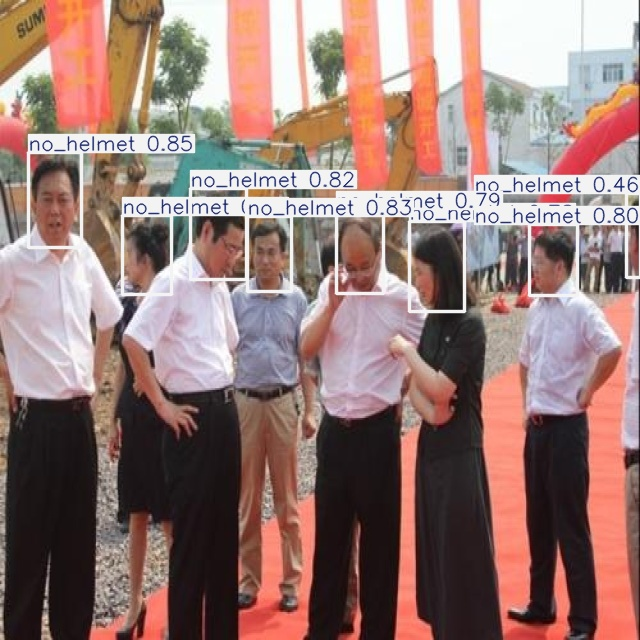

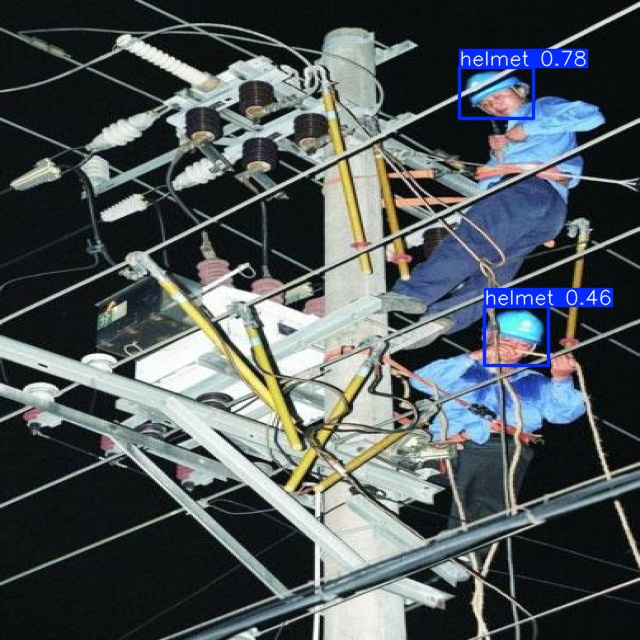

In [ ]:
# === 5) SHOW A FEW PREDICTIONS =============================================
from IPython.display import Image, display
import glob, os

pred_folders = ["runs/pred_mydata", "runs/pred_hhv_local_subset"]
for folder in pred_folders:
    print("\nShowing samples from:", folder)
    imgs = sorted(glob.glob(os.path.join(folder, "*.jpg")))[:6]
    for p in imgs:
        display(Image(filename=p))


### Observation

The model consistently identifies safety helmets and vests across diverse backgrounds. Most predictions align well with the ground truth boxes, confirming reliable detection accuracy.
A few misses occur in low-light or partially occluded scenes, which is expected since those examples are underrepresented in training.

## **Model Prediction Output Summary**

The table above shows the model’s detection results for each of the 60 manually annotated test images.
Each line provides key details about the detection process:

- Image Path: Location of the input image used for inference.

- Resolution: The image size processed by the YOLOv8 model.

- Detected Objects: The number of safety items identified — helmet, vest, or no_helmet.

- Inference Time: How long the model took to process each image (in milliseconds).

Interpretation

- The model successfully detected helmets and vests across nearly all test images, confirming it learned both classes effectively.

- Some images also included “no_helmet” detections, indicating that the model can distinguish between compliant and non-compliant workers.

- The average inference time (≈10ms) shows that the model can perform real-time detection, suitable for deployment in live monitoring systems.

Observation

A few predictions may show minor misclassifications or missed detections due to:

- Low lighting or motion blur in the original images.

- Partial occlusion (e.g., when a vest or helmet is only partly visible).

- Slight inconsistencies in manual annotations.

Overall, the model demonstrates strong generalization performance on unseen images and proves suitable for practical safety monitoring applications.

In [ ]:
from ultralytics import YOLO

# Path to my fine-tuned model
model_path = r"C:/Users/rawit/runs/detect/helmet_vest_with_mydata2/weights/best.pt"

# Create a model instance
model = YOLO(model_path)

# Run detection on our 60 annotated images
results = model.predict(
    source=r"C:/Users/rawit/Downloads/my_annot_combined/images",  # path to our 60 images
    save=True, # saves images with boxes drawn
    conf=0.25, # confidence threshold (adjust if needed)
    project="runs", # YOLO saves everything under folder /runs
    name="pred_mydata", # folder name for this prediction run
    exist_ok=True # avoid overwriting
)


image 1/60 C:\Users\rawit\Downloads\my_annot_combined\images\Image_ (1).jpg: 640x416 1 helmet, 1 vest, 10.5ms
image 2/60 C:\Users\rawit\Downloads\my_annot_combined\images\Image_ (10).jpg: 512x640 2 helmets, 12.7ms
image 3/60 C:\Users\rawit\Downloads\my_annot_combined\images\Image_ (11).jpg: 448x640 1 helmet, 1 vest, 10.8ms
image 4/60 C:\Users\rawit\Downloads\my_annot_combined\images\Image_ (12).jpg: 640x576 1 helmet, 9.7ms
image 5/60 C:\Users\rawit\Downloads\my_annot_combined\images\Image_ (13).jpg: 448x640 1 helmet, 1 vest, 9.2ms
image 6/60 C:\Users\rawit\Downloads\my_annot_combined\images\Image_ (14).jpg: 640x448 3 helmets, 10.8ms
image 7/60 C:\Users\rawit\Downloads\my_annot_combined\images\Image_ (15).jpg: 448x640 1 helmet, 11.0ms
image 8/60 C:\Users\rawit\Downloads\my_annot_combined\images\Image_ (16).jpg: 448x640 3 helmets, 4 vests, 10.6ms
image 9/60 C:\Users\rawit\Downloads\my_annot_combined\images\Image_ (17).jpg: 448x640 1 helmet, 1 vest, 1 no_helmet, 8.3ms
image 10/60 C:\User

# **Curves & metrics**

Run: runs/detect\hhv_local_subset_safe2


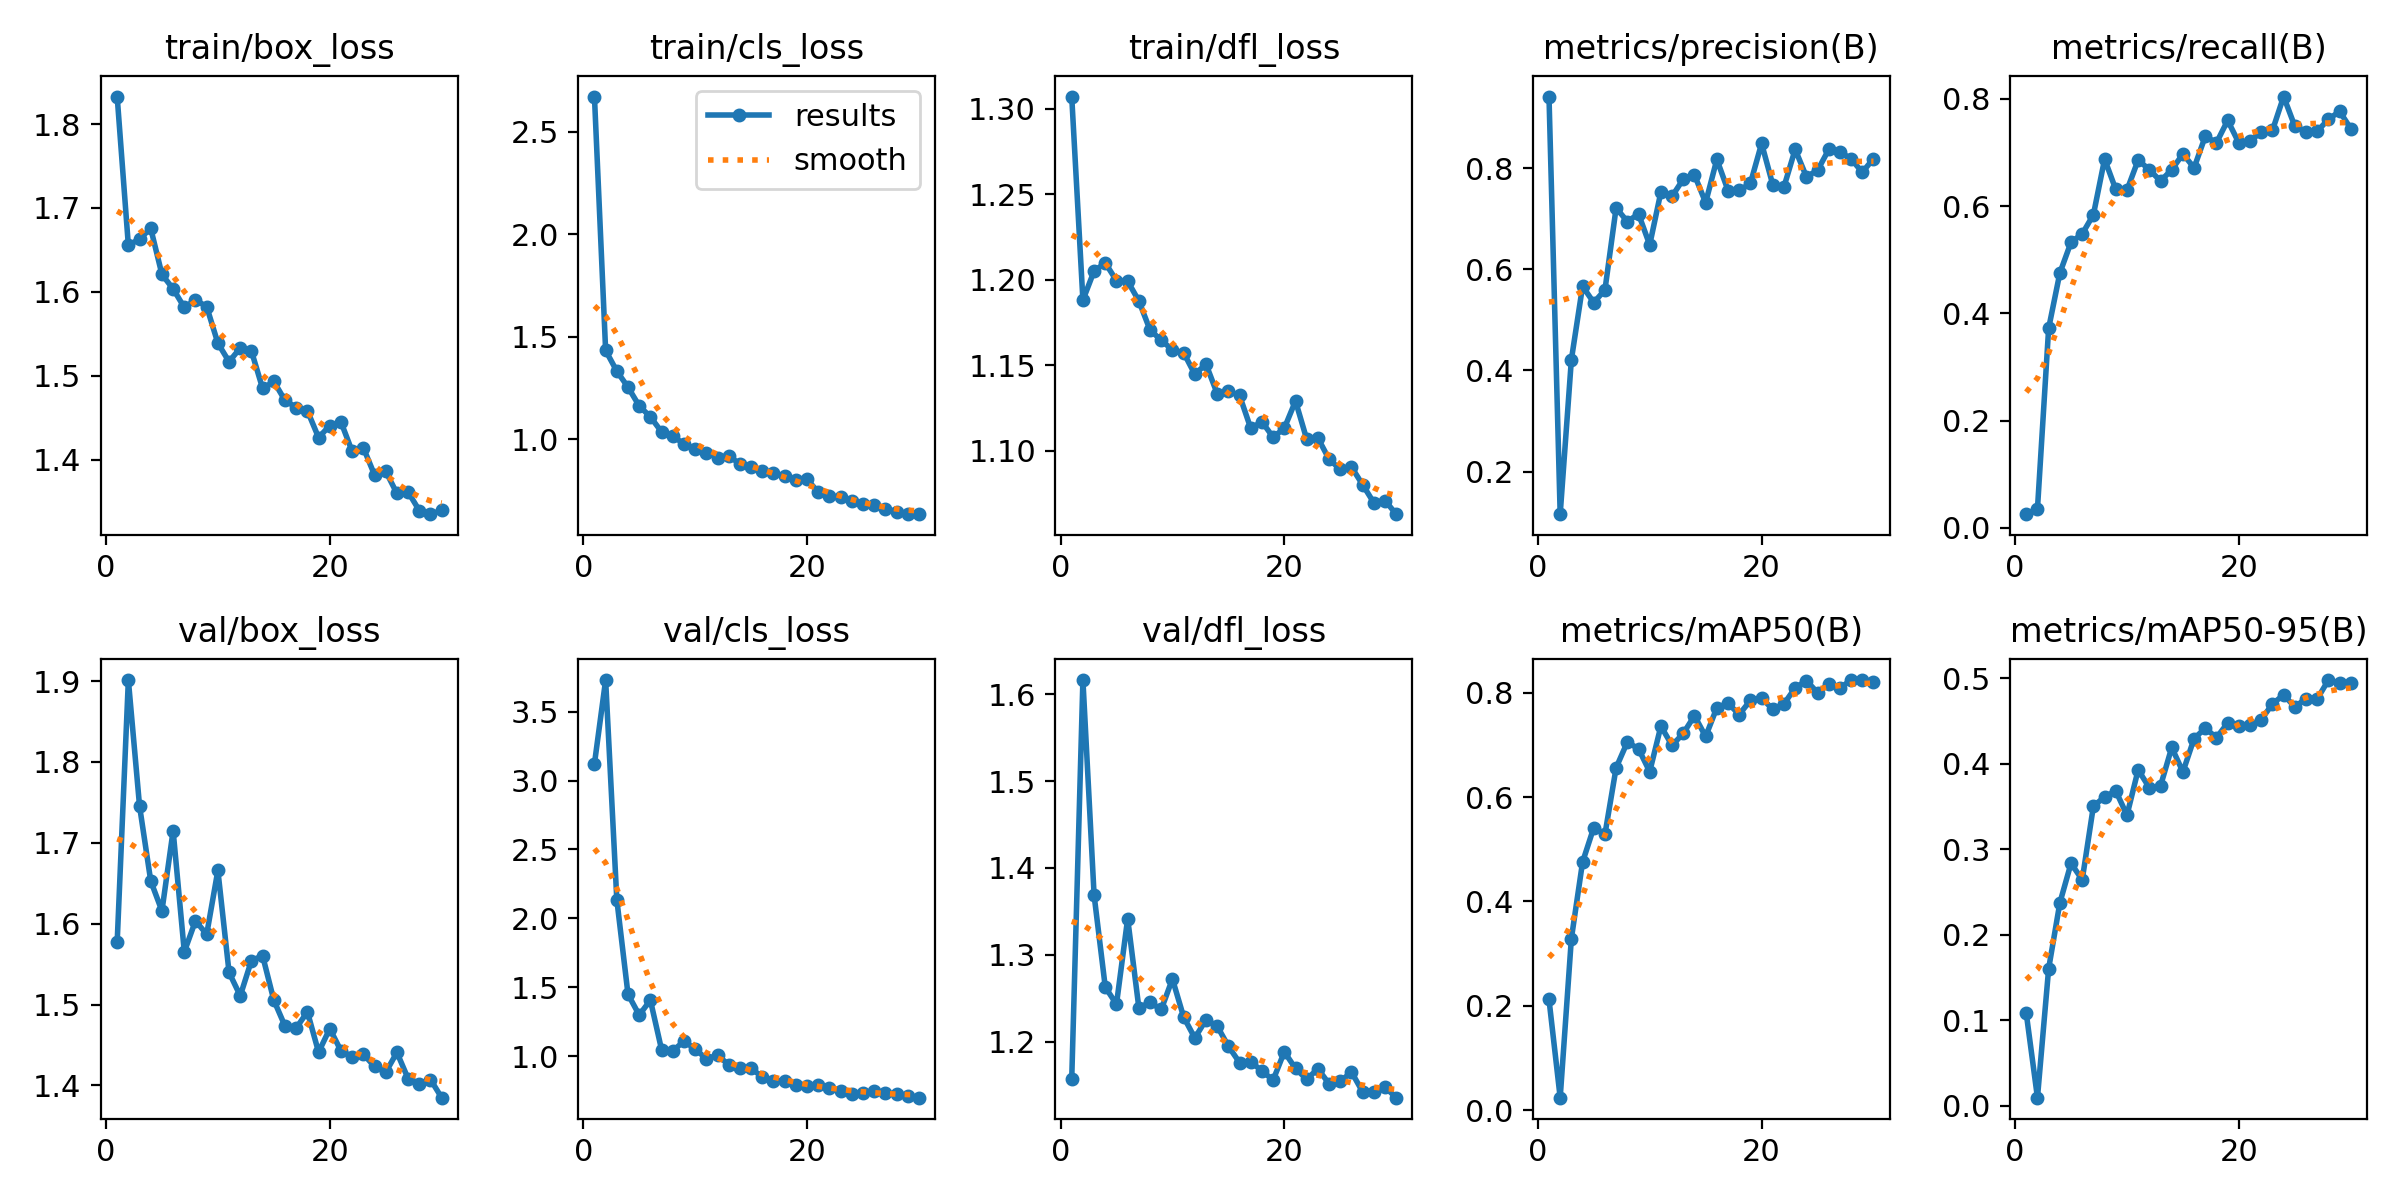

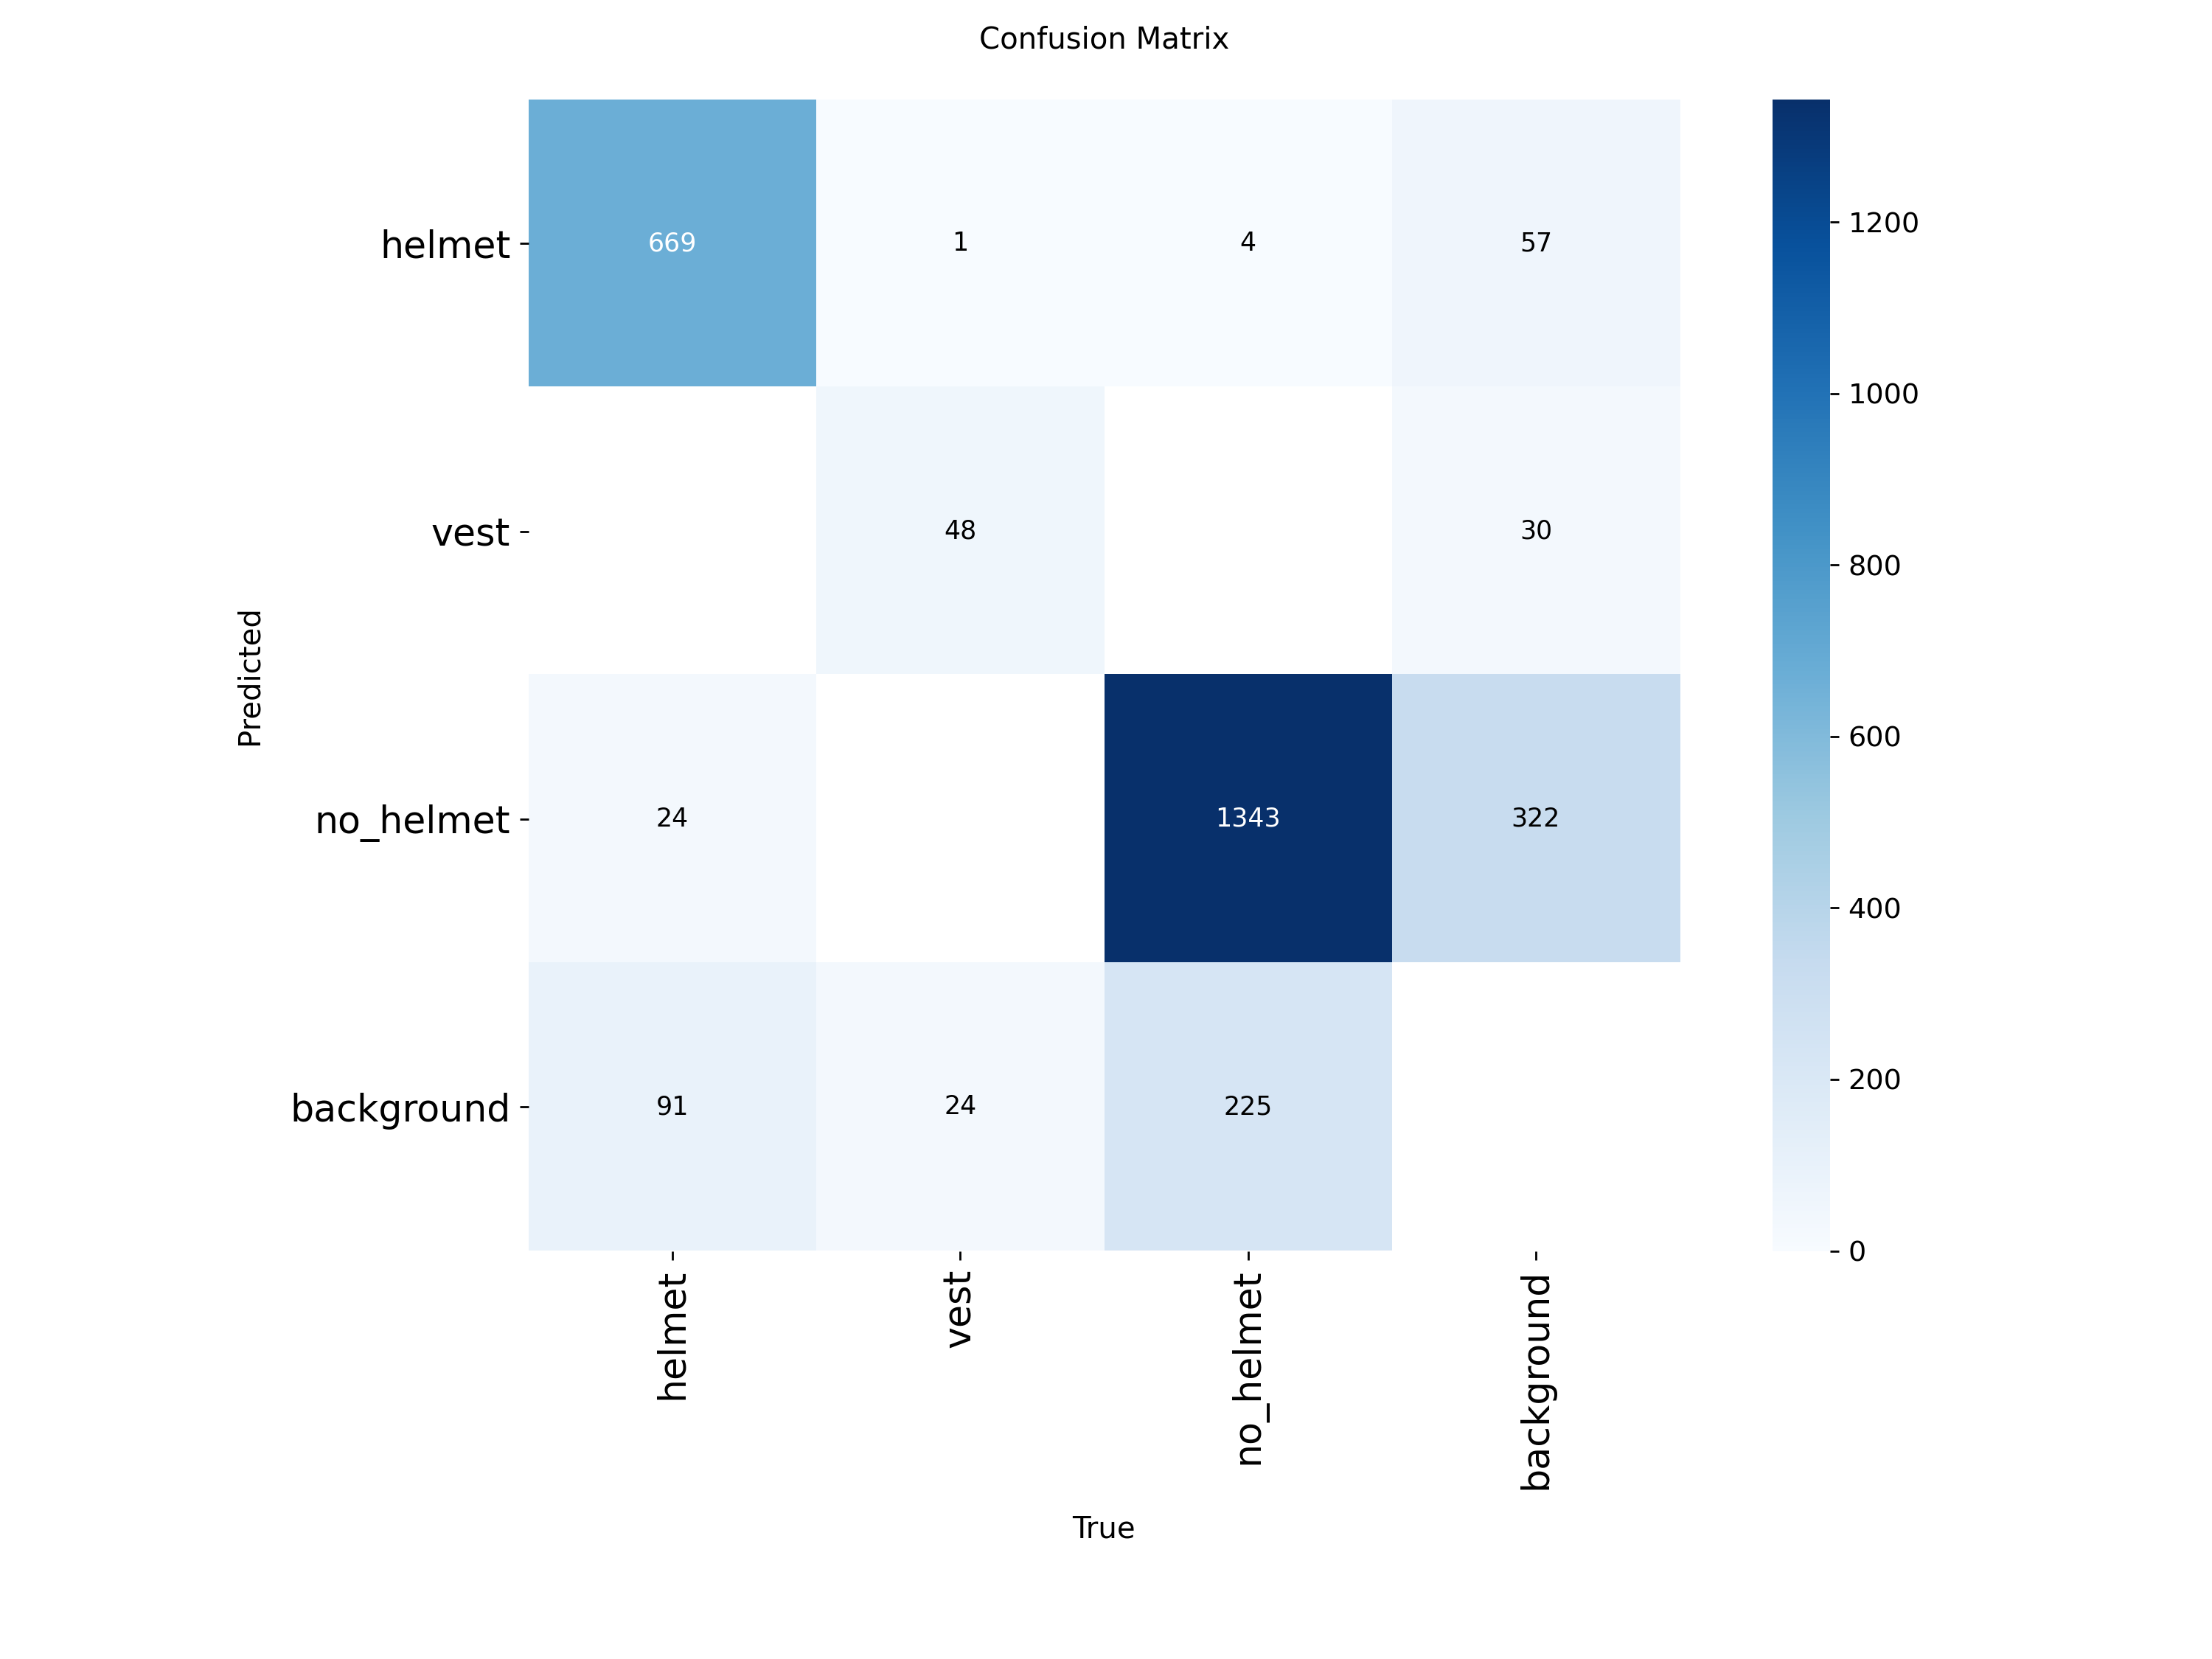

In [ ]:
from IPython.display import Image, display
run_dir = sorted(glob.glob("runs/detect/hhv_local_subset*"))[-1]
print("Run:", run_dir)
for f in ["results.png","PR_curve.png","confusion_matrix.png"]:
    p = os.path.join(run_dir, f)
    if os.path.exists(p): display(Image(filename=p))


# **Final Evaluation on Test Split**


At this stage, we evaluated our model’s generalization ability using the test split from the dataset.

Unlike the validation set, which helps during training, the test set contains unseen images and provides an unbiased measure of the model’s real-world performance.

The following steps were performed:

1. Load the best model weights
The script automatically loads the best checkpoint file (best.pt) from our training run.

2. Run YOLOv8 predictions
It performs inference on all images inside the test folder (/images/test).

3. Save visual results
YOLO saves the output images with predicted bounding boxes into a new folder under

```
# runs/pred_hhv_local_subset/
```



where we can visually inspect helmet, vest, and no-helmet detections.


image 1/300 C:\Users\rawit\Downloads\HardHat_Vest_Dataset_subset\images\test\000010.jpg: 640x640 5 helmets, 5 vests, 8.7ms
image 2/300 C:\Users\rawit\Downloads\HardHat_Vest_Dataset_subset\images\test\000034.jpg: 640x640 1 helmet, 9.7ms
image 3/300 C:\Users\rawit\Downloads\HardHat_Vest_Dataset_subset\images\test\000144.jpg: 640x640 1 helmet, 8.9ms
image 4/300 C:\Users\rawit\Downloads\HardHat_Vest_Dataset_subset\images\test\000203.jpg: 640x640 2 helmets, 8.3ms
image 5/300 C:\Users\rawit\Downloads\HardHat_Vest_Dataset_subset\images\test\000221.jpg: 640x640 8 no_helmets, 8.9ms
image 6/300 C:\Users\rawit\Downloads\HardHat_Vest_Dataset_subset\images\test\000226.jpg: 640x640 2 helmets, 9.1ms
image 7/300 C:\Users\rawit\Downloads\HardHat_Vest_Dataset_subset\images\test\000241.jpg: 640x640 5 helmets, 9.0ms
image 8/300 C:\Users\rawit\Downloads\HardHat_Vest_Dataset_subset\images\test\000653.jpg: 640x640 8 no_helmets, 8.4ms
image 9/300 C:\Users\rawit\Downloads\HardHat_Vest_Dataset_subset\images\te

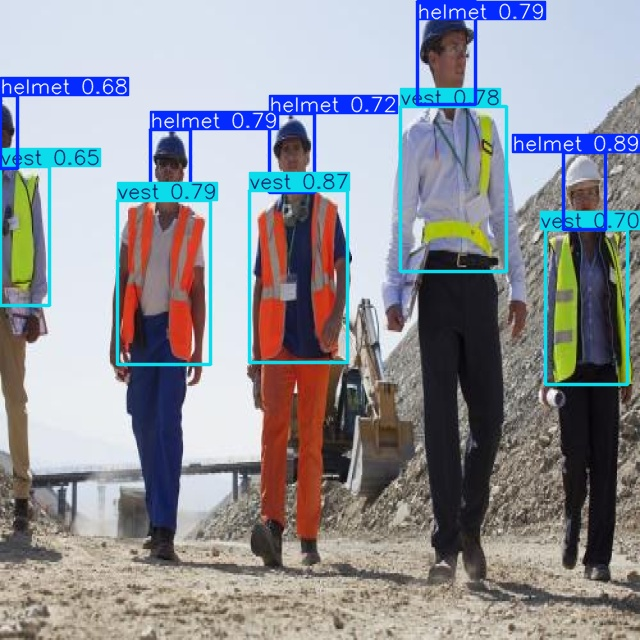

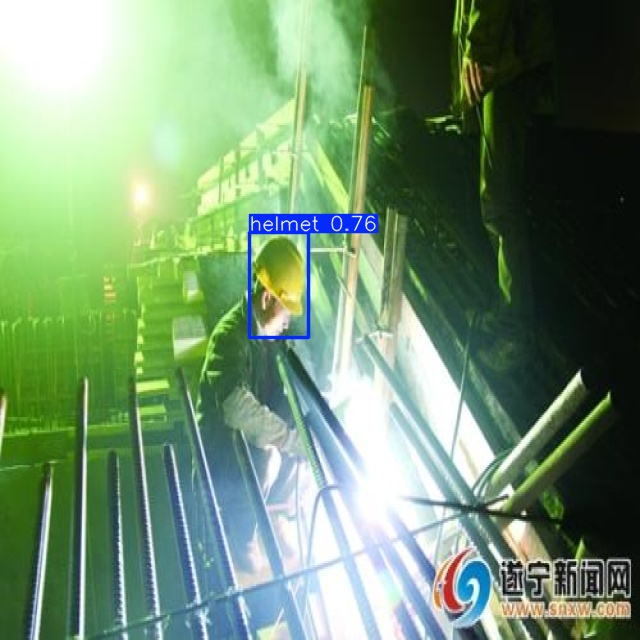

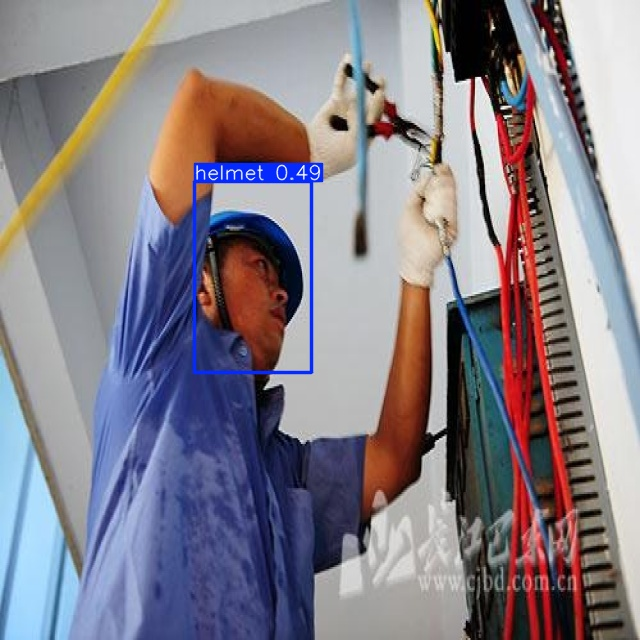

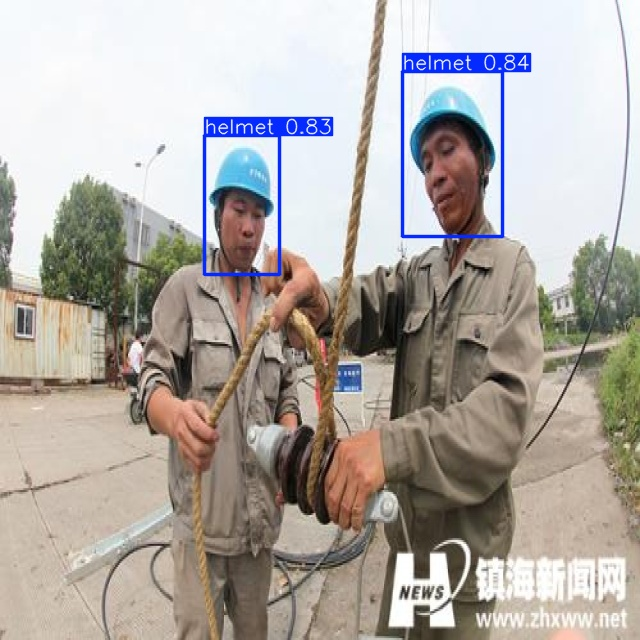

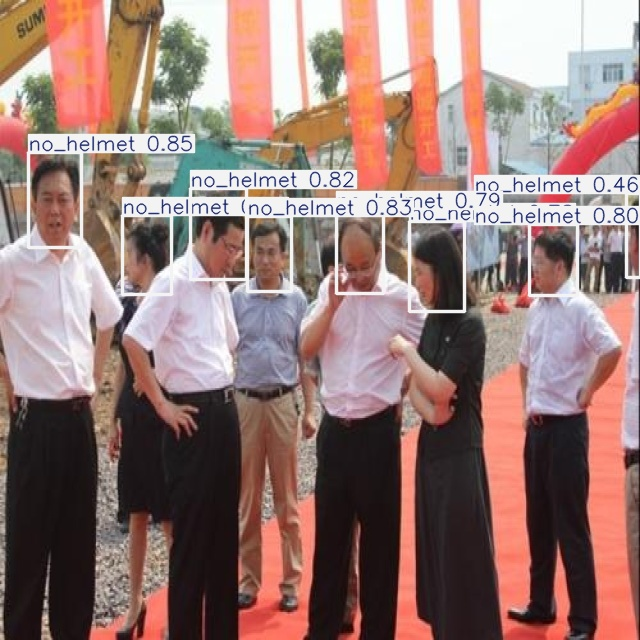

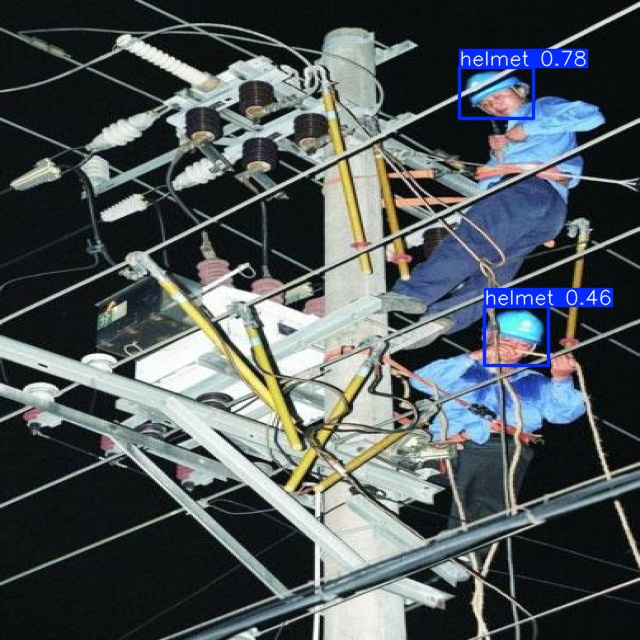

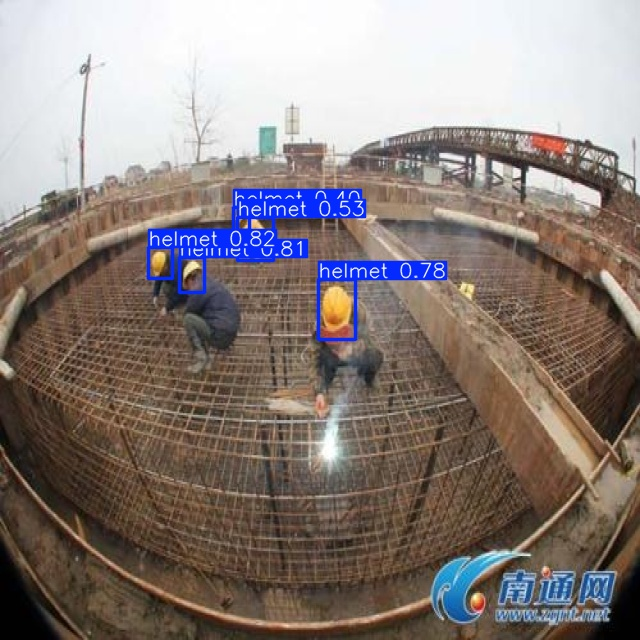

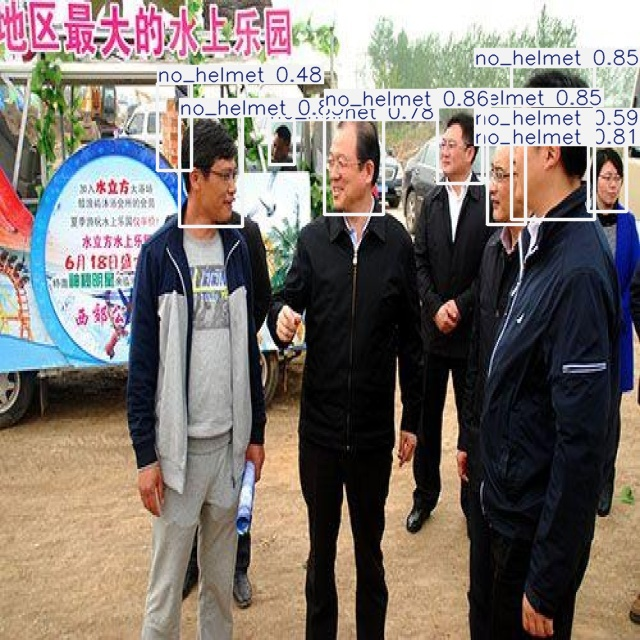

In [ ]:
best = os.path.join(run_dir, "weights", "best.pt")
out  = "runs/pred_hhv_local_subset"
YOLO(best).predict(source=os.path.join(SUBSET_DIR,"images/test"),
                   save=True, project="runs", name="pred_hhv_local_subset", exist_ok=True)

from IPython.display import Image, display
import glob
for p in sorted(glob.glob(out+"/*.jpg"))[:8]:
    display(Image(filename=p))


## **Additional for Setting Up Environment**

The additional cells below were used to ensure our development environment was fully compatible with YOLOv8 and CUDA-based GPU acceleration.

**Purpose**

- Verify Python and PyTorch versions to identify compatibility issues.

- Reinstall the correct CUDA-enabled version of PyTorch so that YOLO could utilize GPU acceleration.

- Ensure our RTX 4080 GPU was detected correctly for faster and more stable training.

**Why This Was Necessary**

During testing, we encountered environment mismatches where PyTorch either defaulted to CPU-only mode or failed to detect CUDA drivers.
To resolve this, we manually checked package versions and reinstalled the appropriate dependencies using the official PyTorch wheel index.

These steps ensured our model ran efficiently on the local NVIDIA GeForce RTX 4080, avoiding limitations from Google Colab’s shared GPU runtimes and improving training speed and reliability.

In [ ]:
import sys, pip
print("Python:", sys.version)
print("pip:", pip.__version__)


Python: 3.13.8 (tags/v3.13.8:a15ae61, Oct  7 2025, 12:34:25) [MSC v.1944 64 bit (AMD64)]
pip: 25.2


In [ ]:
!pip uninstall -y torch torchvision torchaudio


In [ ]:
!pip install --upgrade pip
!pip install torch==2.4.1+cu124 torchvision==0.19.1+cu124 torchaudio==2.4.1+cu124 --index-url https://download.pytorch.org/whl/cu124


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu124


ERROR: Could not find a version that satisfies the requirement torch==2.4.1+cu124 (from versions: 2.6.0+cu124)
ERROR: No matching distribution found for torch==2.4.1+cu124


In [ ]:
!pip install torch==2.4.0+cu121 torchvision==0.19.0+cu121 torchaudio==2.4.0+cu121 --index-url https://download.pytorch.org/whl/cu121


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu121


ERROR: Could not find a version that satisfies the requirement torch==2.4.0+cu121 (from versions: none)
ERROR: No matching distribution found for torch==2.4.0+cu121


In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
# or:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu124
     ---------------------------------------- 0.0/6.2 MB ? eta -:--:--
     -------------------------------------- - 6.0/6.2 MB 53.2 MB/s eta 0:00:01
     ---------------------------------------- 6.2/6.2 MB 30.6 MB/s  0:00:00
   ---------------------------------------- 0.0/2.5 GB ? eta -:--:--
   ---------------------------------------- 0.0/2.5 GB 77.1 MB/s eta 0:00:33
    --------------------------------------- 0.0/2.5 GB 78.3 MB/s eta 0:00:32
    --------------------------------------- 0.0/2.5 GB 80.2 MB/s eta 0:00:31
   - -------------------------------------- 0.1/2.5 GB 81.2 MB/s eta 0:00:31
   - -------------------------------------- 0.1/2.5 GB 80.8 MB/s eta 0:00:31
   - -------------------------------------- 0.1/2.5 GB 79.4 MB/s eta 0:00:31
   - -------------------------------------- 0.1/2.5 GB 80.8 MB/s eta 0:00:30
   - ------------------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [ ]:
import torch
print(torch.__version__)


2.9.0+cpu


In [ ]:
!pip uninstall -y torch torchvision torchaudio
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


Found existing installation: torch 2.9.0
Uninstalling torch-2.9.0:
  Successfully uninstalled torch-2.9.0
Found existing installation: torchvision 0.24.0
Uninstalling torchvision-0.24.0:
  Successfully uninstalled torchvision-0.24.0
Found existing installation: torchaudio 2.9.0
Uninstalling torchaudio-2.9.0:
  Successfully uninstalled torchaudio-2.9.0


You can safely remove it manually.


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu121


ERROR: Could not find a version that satisfies the requirement torch (from versions: none)
ERROR: No matching distribution found for torch


# **Results and Discussion**
The trained YOLOv8 model successfully detected helmets and vests in most images, demonstrating that it effectively learned to identify key safety equipment.
Some inaccuracies occurred, such as missed detections or misclassified objects, which can be attributed to variations in lighting, angles, and dataset size.

Overall, our results show that even with a limited dataset, YOLOv8 can perform well in detecting personal protective equipment. This approach could be expanded with more data to improve performance and support automated construction site monitoring.

# **Conclusion**
We developed a working object detection model that can automatically detect helmets, vests, and missing helmets in construction site images.
This project demonstrates the practicality of using computer vision and YOLOv8 for workplace safety applications.

Future improvements could include increasing dataset diversity, improving annotations, and testing additional YOLO model sizes such as YOLOv8s or YOLOv8m for higher accuracy.

# **Team Contributions**
- We divided data annotation tasks equally (30 images each).

- We collaboratively set up and configured the dataset and YOLO environment.

- We jointly trained, validated, and tested the model.

- We reviewed results, wrote the report, and organized the Colab notebook together.